In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_path = 'data/mnist/'
url_to_file='http://deeplearning.net/data/mnist/mnist.pkl.gz'
filename='mnist.pkl.gz'

# Download data

In [35]:
import requests
import shutil
import os
from tqdm import tqdm

def download_file(data_path=data_path, url_to_file=url_to_file, filename=filename):
    '''Downlaods file from url_to_file to data_path/filename.
    Could add tqdm to show progress'''
    if os.path.isfile(data_path + filename):
        print('{} was already donwloaded!'.format(filename))
    else:
        os.makedirs(data_path, exist_ok=True)
        r = requests.get(url_to_file, stream=True)
        with open(os.path.join(data_path + filename), 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return filename

In [38]:
test = download_file()

# Load data + preproc

In [3]:
import pickle
import gzip

def depickle(file_path):
    return pickle.load(gzip.open(file_path, 'rb'), encoding='latin-1')

Normalize

In [149]:
((x, y), (x_valid, y_valid), _) = depickle(data_path+filename)

In [150]:
mean = x.mean()
std = x.std()

In [151]:
x = (x-mean)/std
mean, x.mean(), std, x.std()

(0.13044983, -3.1638146e-07, 0.3072898, 0.99999934)

In [152]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [153]:
x.max(), x.min()

(2.8170278, -0.42451727)

# Inspect data

In [8]:
def showim(img, label, index):
    x = np.reshape(img[index,:],(-1, 28,28))
    plt.title('label = '+str(label[index]), fontsize=19)
    plt.imshow(x[0,:,:])

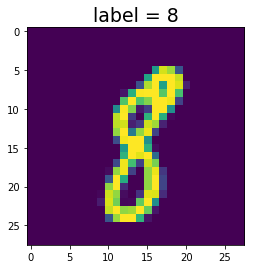

In [9]:
showim(x,y,300)

# Implementation

## Diagram

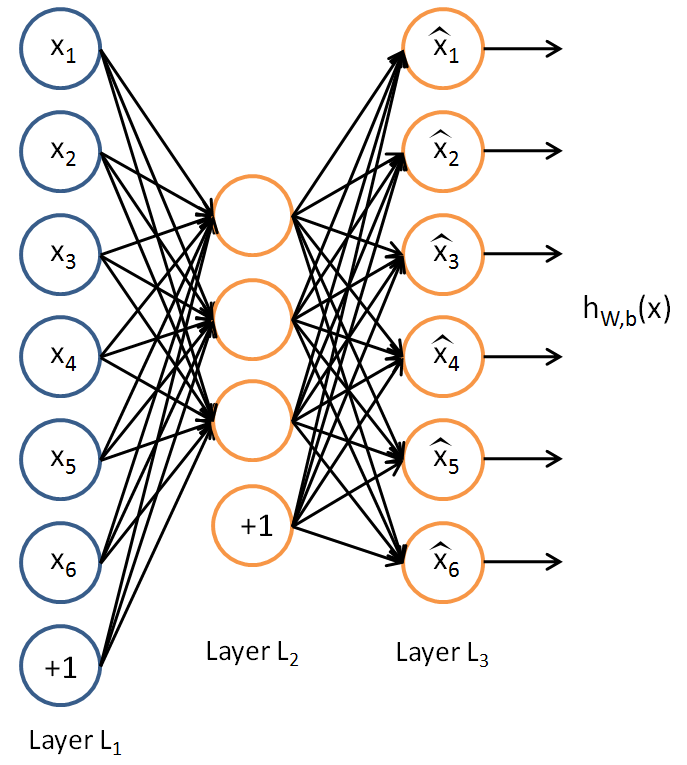

In [44]:
from IPython.display import Image
Image("Autoencoder636.png")

# Code

In [101]:
def relu(x):
    x[x < 0] = 0
    return x
    
def relu_d(x):
     x[x<=0] = 0
     x[x>0] = 1
     return x 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_d(x):
    return sigmoid(x) * (1-sigmoid(x))

def onehot(y):
    size = len(y)
    one = np.zeros((size, 10))
    one[np.arange(size),y] = 1
    return one

def onehot_d(x):
    return np.argmax(x)
    
def generator(bs, examples, labels):
    n_batches = int(np.floor(len(examples)/bs))
    it = 0
    while it <= n_batches*bs-1:
        yield examples[it:it+bs,:], labels[it:it+bs], n_batches
        it += bs
    it = 0
    
# def generator(bs, examples, labels):
#     n_batches = int(np.floor(len(examples)/bs))
#     ids = np.random.permutation(len(examples))
#     it = 0
#     while it <= n_batches*bs-1:
#         yield examples[ids[it:it+bs],:], labels[ids[it:it+bs]], n_batches
#         it += bs
#     it = 0
#     ids = np.random.permutation(len(examples))

## Autoencoder with KL divergence

In [102]:
bs = 32
imdim = 28
outer_layer = imdim**2
hidden_layer = 200

In [103]:
W1 = np.random.rand(outer_layer, hidden_layer)*2-1
W2 = np.random.rand(hidden_layer, outer_layer)*2-1
spar = np.zeros((hidden_layer))

/home/stijn/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


epoch             =  0
loss1   = 1419609.7808140647
loss2   = 726.9685770123328
epoch             =  1
loss1   = 113029.35787833719
loss2   = 723.135227603583
epoch             =  2
loss1   = 120157.67741666899
loss2   = 344.35283010947586
epoch             =  3
loss1   = 197414.39797154756
loss2   = 700.5969663811833
epoch             =  4
loss1   = 105106.5126695473
loss2   = 992.7923339812354
epoch             =  5
loss1   = 117336.4254871269
loss2   = 358.2511275659645
epoch             =  6
loss1   = 247827.9994616171
loss2   = 434.6932825618002
epoch             =  7
loss1   = 101640.21138269824
loss2   = 1012.1348629165394
epoch             =  8
loss1   = 112090.15199434242
loss2   = 416.34245552051567
epoch             =  9
loss1   = 133678.8863305489
loss2   = 363.01205928782593
epoch             =  10
loss1   = 100672.2535607581
loss2   = 722.2590102232941
epoch             =  11
loss1   = 109904.55314883105
loss2   = 558.1238287229457
epoch             =  12
loss1   = 106542

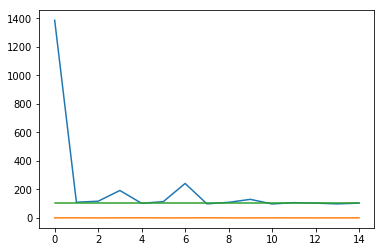

In [121]:
losstot1 = []
losstot2 = []

epochs = 15
eta = 0.1
spar_hp = 0.05
beta = 1.

for i in range(epochs):
    cost1, cost2, j = 0., 0., 0
    spar_new = np.zeros_like(spar)+0.00001
    for a1, labs, n_batches in generator(bs, x, y):
        z2 = np.dot(a1, W1)
        a2 = sigmoid(z2)
        a3 = np.dot(a2, W2)
        
        # cost
        cost1 += np.sum(0.5 * np.abs(a3-a1)**2)
        spar_int = spar
        cost2 += np.sum(spar_hp*np.log(spar_hp/spar_int)+(1-spar_hp)*np.log((1-spar_hp)/(1-spar_int)))
        spar_new += a2.mean(axis=0)
        j += 1
        
        # backward pass
        d3 = a3 - a1
        d2_se = np.dot(d3, W2.T)
        d2_kl = beta*((1-spar_hp)/(1-spar[0])-(spar_hp)/(spar[0]))
        d2 = (d2_se + d2_kl) * sigmoid_d(a2)

        # update weights
        W2 -= eta * np.dot(a2.T,d3) / bs
        W1 -= eta * np.dot(a1.T,d2) / bs
        
        # batch normalization
#         temp = (W1.std(), W1.mean())
#         W1 = (W1 / temp[0])-temp[1]
#         temp = (W2.std(), W2.mean())
#         W2 = (W2 / temp[0])-temp[1]
        
    spar = spar_new / n_batches
    
    if i%(1) == 0:
        print('epoch             = ', i)
        print('loss1   = {}'.format(cost1/j*bs))
        print('loss2   = {}'.format(cost2/j*bs))
    losstot1.append(cost1/(j*bs))
    losstot2.append(cost2/(j*bs))
    
epochnums = np.arange(epochs)
plt.plot(epochnums, losstot1)
plt.plot(epochnums, losstot2)
plt.plot(epochnums, [sum(epochnums) for x in zip(losstot1, losstot2)])
    
print('Done!')

In [154]:
i = 1

In [155]:
a1 = x[i:i+bs, :]
labs = y[i:i+bs]
z2 = np.dot(a1, W1)
a2 = sigmoid(z2)
a3 = np.dot(a2, W2)

/home/stijn/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


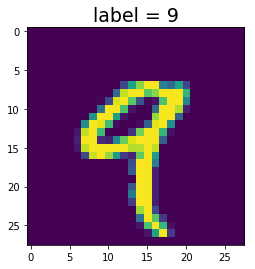

In [160]:
showim(a1, labs, i)

4


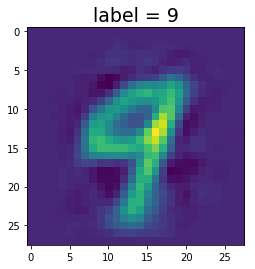

In [161]:
showim(a3, labs, i)
i+=1
print(i)

## Variational autoencoder with KL divergence

Approach:  
It is not entirely clear to me how the $\mu$ and $\sigma$ are generated, are they fully connected to the previous layer?  
In the forward pass, this is however connected in some way. A sample is taken like $\mathcal{N}(\mu,\,\sigma^{2})$ where seperate the funciton that does the sampling. The outcome then is the activation.  
In backprop, would you adjust the weights just to the result of your sample?

In [2]:
bs = 32
imdim = 28
outer_layer = imdim**2
hidden_layer = 200

In [3]:
W1 = np.random.rand(outer_layer, hidden_layer)*2-1
W2 = np.random.rand(hidden_layer, outer_layer)*2-1
spar = np.zeros((hidden_layer))

NameError: name 'np' is not defined

/home/stijn/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


epoch             =  0
loss1   = 1419609.7808140647
loss2   = 726.9685770123328
epoch             =  1
loss1   = 113029.35787833719
loss2   = 723.135227603583
epoch             =  2
loss1   = 120157.67741666899
loss2   = 344.35283010947586
epoch             =  3
loss1   = 197414.39797154756
loss2   = 700.5969663811833
epoch             =  4
loss1   = 105106.5126695473
loss2   = 992.7923339812354
epoch             =  5
loss1   = 117336.4254871269
loss2   = 358.2511275659645
epoch             =  6
loss1   = 247827.9994616171
loss2   = 434.6932825618002
epoch             =  7
loss1   = 101640.21138269824
loss2   = 1012.1348629165394
epoch             =  8
loss1   = 112090.15199434242
loss2   = 416.34245552051567
epoch             =  9
loss1   = 133678.8863305489
loss2   = 363.01205928782593
epoch             =  10
loss1   = 100672.2535607581
loss2   = 722.2590102232941
epoch             =  11
loss1   = 109904.55314883105
loss2   = 558.1238287229457
epoch             =  12
loss1   = 106542

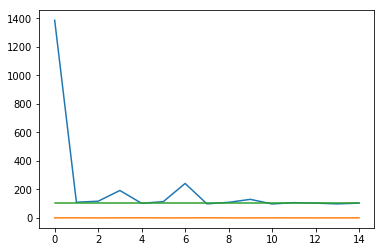

In [121]:
losstot1 = []
losstot2 = []

epochs = 15
eta = 0.1
spar_hp = 0.05
beta = 1.

for i in range(epochs):
    cost1, cost2, j = 0., 0., 0
    spar_new = np.zeros_like(spar)+0.00001
    for a1, labs, n_batches in generator(bs, x, y):
        z2 = np.dot(a1, W1)
        a2 = sigmoid(z2)
        a3 = np.dot(a2, W2)
        
        # cost
        cost1 += np.sum(0.5 * np.abs(a3-a1)**2)
        spar_int = spar
        cost2 += np.sum(spar_hp*np.log(spar_hp/spar_int)+(1-spar_hp)*np.log((1-spar_hp)/(1-spar_int)))
        spar_new += a2.mean(axis=0)
        j += 1
        
        # backward pass
        d3 = a3 - a1
        d2_se = np.dot(d3, W2.T)
        d2_kl = beta*((1-spar_hp)/(1-spar[0])-(spar_hp)/(spar[0]))
        d2 = (d2_se + d2_kl) * sigmoid_d(a2)

        # update weights
        W2 -= eta * np.dot(a2.T,d3) / bs
        W1 -= eta * np.dot(a1.T,d2) / bs
        
        # batch normalization
#         temp = (W1.std(), W1.mean())
#         W1 = (W1 / temp[0])-temp[1]
#         temp = (W2.std(), W2.mean())
#         W2 = (W2 / temp[0])-temp[1]
        
    spar = spar_new / n_batches
    
    if i%(1) == 0:
        print('epoch             = ', i)
        print('loss1   = {}'.format(cost1/j*bs))
        print('loss2   = {}'.format(cost2/j*bs))
    losstot1.append(cost1/(j*bs))
    losstot2.append(cost2/(j*bs))
    
epochnums = np.arange(epochs)
plt.plot(epochnums, losstot1)
plt.plot(epochnums, losstot2)
plt.plot(epochnums, [sum(epochnums) for x in zip(losstot1, losstot2)])
    
print('Done!')

In [154]:
i = 1

In [155]:
a1 = x[i:i+bs, :]
labs = y[i:i+bs]
z2 = np.dot(a1, W1)
a2 = sigmoid(z2)
a3 = np.dot(a2, W2)

/home/stijn/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


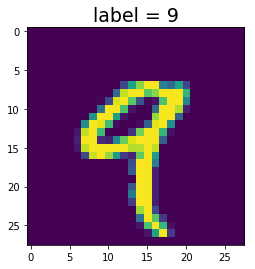

In [160]:
showim(a1, labs, i)

4


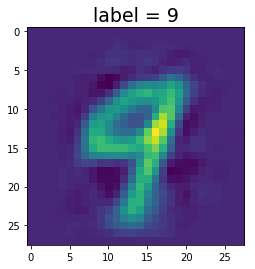

In [161]:
showim(a3, labs, i)
i+=1
print(i)

# Plus batchnorm, shuffled generator

In [145]:
def entropy_spread(x): #breuklijn, 1/x is de kans op het klein deel
    p1 = 1/x
    p2 = 1 - 1/x
    return p1*np.log2(p1)+p2*np.log2(p2)

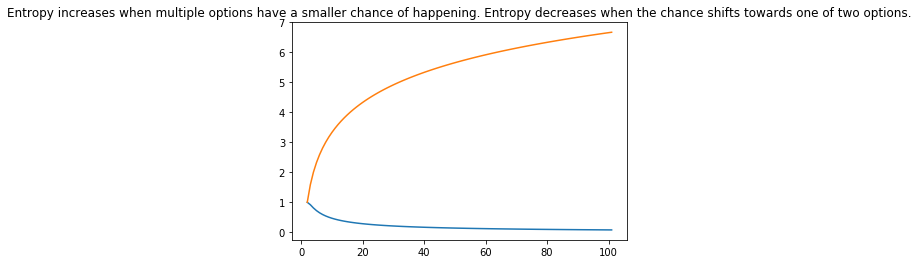

In [148]:
steps = np.arange(100)+2
plt.title('Entropy increases when multiple options have a smaller chance of happening. '
          'Entropy decreases when the chance shifts towards one of two options.')

plt.plot(steps, -entropy_spread(steps))
plt.plot(steps, -np.log2(1/steps))

## Links

**Autoencoder:**  
Basics: http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/  
Arxiv Insights: https://www.youtube.com/watch?v=9zKuYvjFFS8  
Entropy, Cross entropy and KL divergence: https://www.youtube.com/watch?v=ErfnhcEV1O8  
KL divergence: https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/  
**Articles:**  
VAE: https://arxiv.org/pdf/1312.6114.pdf  
Disentangled VAE: https://arxiv.org/pdf/1606.05579.pdf  
Disentangled VAE in RL: https://arxiv.org/pdf/1707.08475.pdf  
**Bayesian statistics:**  
MIT: https://www.youtube.com/watch?v=bFZ-0FH5hfs  
Khan like: https://www.youtube.com/watch?v=0LQmZXCWMFI  
